In [121]:
import pickle
import pandas as pd
import numpy as np
# plots
import seaborn as sns
import matplotlib.pyplot as plt
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance # feature importance

In [34]:
data = pd.read_pickle('data.pkl copy')

In [35]:
pd.set_option('max_rows', 110)
data.dtypes

gameid                                  int64
playid                                  int64
team                                   object
x                                     float64
y                                     float64
s                                     float64
a                                     float64
dis                                   float64
orientation                           float64
dir                                   float64
nflid                                   int64
displayname                            object
jerseynumber                            int64
season                                  int64
yardline                                int64
quarter                                 int64
gameclock                              object
possessionteam                         object
down                                    int64
distance                                int64
fieldposition                          object
homescorebeforeplay               

## Most machine learning algorithms require numeric data
 - convert object and string variables to numeric
 - use dummy variables

In [37]:
## convert the game clock to seconds
def strtoseconds(txt):
    # get the different parts of the time
    txt = txt.split(':')
    # new time will be in seconds
    # minutes * 60 + seconds + microseconds/60
    new_time = int(txt[0])*60 + int(txt[1]) + int(txt[2])/60
    return new_time
data['gameclock'] = data['gameclock'].apply(strtoseconds)

In [47]:
# convert ol ot integer
data['ol'] = data['ol'].astype(int)

In [45]:
cols_to_keep = ['team',
 's',
 'a',
 'dis',
 'orientation',
 'dir',
 'season',
 'yardline',
 'quarter',
 'gameclock',
 'possessionteam',
 'down',
 'distance',
 'fieldposition',
 'homescorebeforeplay',
 'visitorscorebeforeplay',
 'offenseformation',
 'offensepersonnel',
 'defendersinthebox',
 'defensepersonnel',
 'yards', # this is the target variable - remove this for the test set
 'playerheight',
 'playerweight',
 'playercollegename',
 'position',
 'hometeamabbr',
 'visitorteamabbr',
 'week',
 'age',
 'time_since_snap',
 'rusher',
 'rushx',
 'rushy',
 'disttorush',
 'teamidentity',
 'min_distancetorusher',
 'ol_d',
 'dl',
 'lb',
 'db',
 'rb_d',
 'qb',
 'ol',
 'rb',
 'te',
 'wr',
 'dl_o',
 'lb_o',
 'db_o',
 'yardfromowngoal',
 'x_standard',
 'y_standard',
 'avgyardspergame',
 'x_handoff',
 'y_handoff',
 '1_sec_x',
 '1_5_sec_x',
 '2_sec_x',
 '2_5_sec_x',
 '3_sec_x',
 '3_5_sec_x',
 '4_sec_x',
 '4_5_sec_x',
 '5_sec_x',
 '5_5_sec_x',
 '6_sec_x',
 '1_sec_y',
 '1_5_sec_y',
 '2_sec_y',
 '2_5_sec_y',
 '3_sec_y',
 '3_5_sec_y',
 '4_sec_y',
 '4_5_sec_y',
 '5_sec_y',
 '5_5_sec_y',
 '6_sec_y',
 'offense',
 'eff_downfield_acc',
 'eff_crossfield_acc',
 'rushteamwinning',
 'playerblocked',
 'total_playersblocked']

In [50]:
### Get dummy variables for categorical variables (object type)
num_data = data[cols_to_keep]
num_data = pd.get_dummies(num_data)

(682154, 687)

In [91]:
## use 2017 and 2018 to predict 2019

# input variables
trainX = num_data.loc[num_data['season'] != 2019]
testX = num_data.loc[num_data['season'] == 2019]
# labels
trainY = trainX['yards']
testY = testX['yards']
# drop labels from input variables
#trainX.drop('yards', axis = 1, inplace = True)
#trainY.drop('yards', axis = 1, inplace = True)

print('# of Train Plays: {}   # of Test Plays: {}'.format(int(trainX.shape[0]/22), int(testX.shape[0]/22)))
print('# of Train Labels: {}  # of Test Labels: {}'.format(int(trainY.shape[0]/22), int(testY.shape[0]/22)))
print('All Plays Covered: {}'.format(trainX.shape[0] + testY.shape[0] == num_data.shape[0]))

# of Train Plays: 23171   # of Test Plays: 7836
# of Train Labels: 23171  # of Test Labels: 7836
All Plays Covered: True


In [103]:
# Bin the yards
data['yards'].describe()

count    682154.000000
mean          4.227626
std           6.449866
min         -15.000000
25%           1.000000
50%           3.000000
75%           6.000000
max          99.000000
Name: yards, dtype: float64

In [101]:
## get subsets (1000 plays) to test models
# get 2017
df17 = num_data.loc[num_data['season'] == 2017]
df18 = num_data.loc[num_data['season'] == 2018]
df17.index = range(len(df17))
df18.index = range(len(df18))
sub17 = df17[:22000]
sub18 = df18[:22000]
sub_trainX = pd.concat([sub17, sub18])
sub_trainY = sub_trainX['yards']
sub_testX = testX[:22000]
sub_testY = sub_testX['yards']
# drop the target variable
sub_trainX.drop('yards', axis = 1, inplace = True)
sub_testX.drop('yards', axis = 1, inplace = True)
print(sub_trainX.shape, sub_trainY.shape)
print(sub_testX.shape, sub_testY.shape)
# delete temporary dfs
del df17, df18, sub17, sub18

(44000, 686) (44000,)
(22000, 686) (22000,)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


# Random Forest
_requires numeric values_ <br>
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [102]:
rf = RandomForestClassifier(n_estimators = 100, # number of trees
                           min_samples_split = 3,
                           oob_score = True)
rf.fit(sub_trainX, sub_trainY)
print(rf.score(sub_testX, sub_testY))

0.11836363636363637


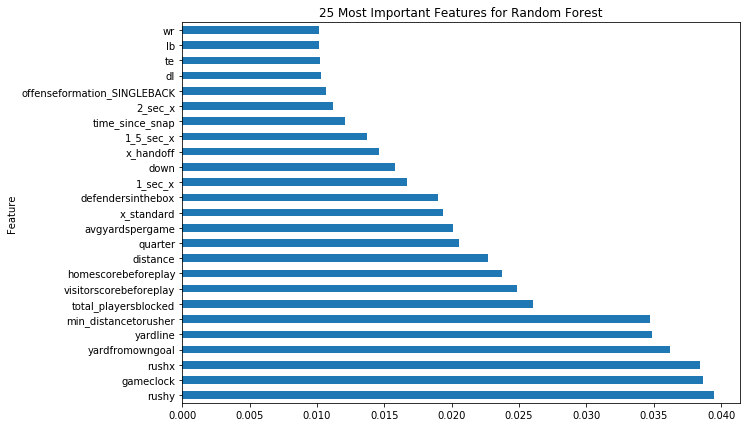

Features
rushy                          0.039440
gameclock                      0.038659
rushx                          0.038404
yardfromowngoal                0.036173
yardline                       0.034851
min_distancetorusher           0.034692
total_playersblocked           0.026030
visitorscorebeforeplay         0.024839
homescorebeforeplay            0.023700
distance                       0.022683
quarter                        0.020524
avgyardspergame                0.020087
x_standard                     0.019321
defendersinthebox              0.019019
1_sec_x                        0.016668
down                           0.015774
x_handoff                      0.014592
1_5_sec_x                      0.013741
time_since_snap                0.012061
2_sec_x                        0.011216
offenseformation_SINGLEBACK    0.010671
dl                             0.010324
te                             0.010252
lb                             0.010174
wr                             

In [137]:
## Print n most important features
n = 25
plt.figure(figsize = (10, 7))
# impurity-based feature importance
importances = pd.Series(rf.feature_importances_, index = sub_trainX.columns)
# sort values in descending order
importances = importances.sort_values(ascending = False)
# horizontal barplot
importances.nlargest(25).plot(kind = 'barh')
plt.title('25 Most Important Features for Random Forest')
plt.ylabel('Feature')
plt.show()
print('Features')
print(importances[:25])

In [134]:
data['total_playersblocked'].unique()

array([11, 10,  8,  6,  9,  7,  4,  5,  2,  3,  1, 12])